In [26]:
import boto3
import botocore
import sagemaker
import sys

bucket = 'ads-bucket-senichol'   # <--- specify a bucket you have access to
prefix = 'kaggle-crypto-data/RCF'

# I am overwriting the bucket and prefix variables since I can't write to Scott's bucket
bucket = 'sagemaker-davidrob'
prefix = 'group-project/bitcoin'

execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))
    
import os
os.system('spd-say "your program has finished"')

Training input/output will be stored in: s3://sagemaker-davidrob/group-project/bitcoin


32512

In [2]:
# Step 1: get the bitcoin minute-by-minute data from kaggle (one way or another)
# https://www.kaggle.com/mczielinski/bitcoin-historical-data
# https://www.kaggle.com/mczielinski/bitcoin-historical-data#bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv
    
#import pandas as pd
#!pip install kaggle
#!kaggle datasets download -d mczielinski/bitcoin-historical-data
#!mkdir bitcoin-historical-data
#!mv bitcoin-historical-data.zip /bitcoin-historical-data
#!unzip -a /bitcoin-historical-data/bitcoin-historical-data.zip
#df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv', encoding="ISO-8859-1", low_memory=False)

# Either run the lines above this comment or do something like the lines below.

# I saved and unzipped the file to my instance via the above lines, but ran into some difficulty reading it. 
# I tried messing with the path a bit, and then gave up and just read the data from my own S3 bucket
import pandas as pd
import io
s3 = boto3.client('s3')
raw_data = s3.get_object(Bucket=bucket, Key=f'group-project/bitcoin/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
df = pd.read_csv(io.BytesIO(raw_data['Body'].read()), encoding="ISO-8859-1", low_memory=False)

In [3]:
# Step 2: Add day and hour data elements to the dataframe so we can group by days and hours in later analysis

from datetime import datetime
# create various date formats for grouping later on
df['Time'] = pd.to_datetime(df['Timestamp'], unit = 's', infer_datetime_format = 'True')
df['Date'] = df['Time'].values.astype('datetime64[D]')
df['Hour'] = df['Time'].values.astype('datetime64[h]')
df['Minute'] = df['Time'].values.astype('datetime64[m]')

df.drop(columns=['Time', 'Timestamp'])

# reality check - make sure the dataframe looks right so far.
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Time,Date,Hour,Minute
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:53:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:54:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:55:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:56:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:56:00


In [4]:
#Step 3:  Make the timestamp the index of the dataframe, and drop several fields (minute, high, low, & close)
from sagemaker import RandomCutForest
df_minute_inferences = df[['Minute','Open', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']]
df_minute_inferences = df_minute_inferences.set_index(pd.DatetimeIndex(df_minute_inferences['Minute']).values)
df_minute_inferences = df_minute_inferences.drop(columns = ['Minute'])

df_minute_inferences.head()

,Open,Volume_(BTC),Volume_(Currency),Weighted_Price
2011-12-31 07:52:00,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,4.39,0.455581,2.0,4.39
2011-12-31 07:54:00,4.39,0.455581,2.0,4.39
2011-12-31 07:55:00,4.39,0.455581,2.0,4.39
2011-12-31 07:56:00,4.39,0.455581,2.0,4.39


The following code block is a bit of a placeholder or proof-of-concept. I am breaking up the data into month-sized chunks of minute-level data.

I doubt that we'll actually want a month's worth of data. But once we decide what slice we want, we can replace the following code with something that subsets our data how we will want it.

In [5]:
# Step 4: divide data into month-sized chunks, but keep all chunks in a dictionary

# In this section I am creating a dictionary. The dictionary contains 79 items, one for each month, where the key is 'yyyy-mm' 
# and the value is a dataframe containing that month's minute-level data

from datetime import datetime

rng = pd.date_range('2011-12-01', periods=79, freq='1M')
df_month_ranges = pd.DataFrame({'begin': [d.strftime("%Y-%m-01") for d in rng], 'end': [d for d in rng]}, index=[d.strftime("%Y-%m") for d in rng])

dict_monthly_ranges_of_minutes = {}
for index, row in df_month_ranges.iterrows():
    data = df_minute_inferences.loc[row['begin']:row['end']]
    dict_monthly_ranges_of_minutes.update({index: data})

# Display a random month to illustrate how to retrieve things from this dict.
# Even though the containing object is a dicitionary, pulling out one object by referring to its key will return a dataframe
# (The "scored" name is a little premature. It doesn't currently contain scores, but it will shortly.)
# Apparently, the .copy method is bad form, but I needed to do something to avoid an error a few steps below.
df_scored = dict_monthly_ranges_of_minutes['2017-11'].copy(deep=True)
print(df_scored.head())

# with this dictionary, we can run a separate RCF analysis on each month. 
# I'm not sure if that is going to be useful, but I wanted to see if anything interesting would show up.
# We'll probably want to extract subsets other than calendar months, but hopefully this code will be useful somehow.


                        Open  Volume_(BTC)  Volume_(Currency)  Weighted_Price
2017-11-01 00:00:00  6434.24     17.754522      114013.699750     6421.671199
2017-11-01 00:01:00  6416.91     13.609302       87246.875952     6410.826787
2017-11-01 00:02:00  6405.26     60.684594      388190.958950     6396.861772
2017-11-01 00:03:00  6395.58      4.363766       27905.246032     6394.762209
2017-11-01 00:04:00  6395.10      0.487655        3119.499754     6396.938512


In the following section, change what is passed into the fit() method with the subset(s) from the above section.

In [6]:
# Step 5: build the model

session = sagemaker.Session()
# specify general training job information
rcf_minute = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=500,
                      num_trees=200)

# automatically upload the training data to S3 and run the training job
rcf_minute.fit(rcf_minute.record_set(df_scored.values))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-10-05-03-43-51-322


2018-10-05 03:43:51 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training...
2018-10-05 03:45:24 Downloading - Downloading input data
2018-10-05 03:45:33 Training - Downloading the training image...
2018-10-05 03:46:14 Uploading - Uploading generated training model
2018-10-05 03:46:20 Completed - Training job completed

Docker entrypoint called with argument(s): train
[10/05/2018 03:46:10 INFO 140405299500864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[10/05/2018 03:46:10 INFO 140405299500864] Reading provided configuration fro

Billable seconds: 56


In [7]:
# Step 6:  spin up endpoint instance(s) for generating anamaly scores. 

rcf_inference = rcf_minute.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-10-05-03-46-36-562
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-10-05-03-43-51-322


---------------------------------------------------------------------!

In [13]:
# Step 7: define the file format for sending the data to the endpoint for inference calculations

from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer


In [14]:
# Step 8: Here we take the selected data and reformat it according to the format we just specified in step 7.
df_scored_numpy = df_scored.as_matrix()

# reality check - what do the first few items in this array matrix like?
print(df_scored_numpy[:6])

[[6.43424000e+03 1.77545216e+01 1.14013700e+05 6.42167120e+03]
 [6.41691000e+03 1.36093017e+01 8.72468760e+04 6.41082679e+03]
 [6.40526000e+03 6.06845939e+01 3.88190959e+05 6.39686177e+03]
 [6.39558000e+03 4.36376602e+00 2.79052460e+04 6.39476221e+03]
 [6.39510000e+03 4.87655110e-01 3.11949975e+03 6.39693851e+03]
 [6.39558000e+03 2.59375637e+00 1.66066326e+04 6.40254142e+03]]


In [15]:
# Step 9: generate anomaly scores using the endpoints.

results = rcf_inference.predict(df_scored_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to selected dataframe and print first few values
df_scored['score'] = pd.Series(scores, index=df_scored.index)
print(df_scored.head())


# This section is useful when scoring all 3.4 million records (Would be use instead of the few lines above.)
# Let's try breaking it up into ~340 chunks of 10,000 records 
#df_minute_inferences_numpy = dict_monthly_ranges_of_minutes['2015-03'].as_matrix()

#from collections import defaultdict
#results = defaultdict(list)

# this function splits the dataset into subsets of n records each
#def get_every_n(a, n=2):
#    counter = 0
#    print("Starting " + str((a.shape[0] // n) + 1) + " inference batches.")
#    for i in range((a.shape[0] // n) + 1):
#        if (counter == 10):
#            print(i)
#            counter = 0
#        yield a[n*i:n*(i+1)]
#        counter += 1

#for subset in get_every_n(df_minute_inferences_numpy,10000):
#    subset_results = rcf_inference.predict(subset)
#    for score in subset_results['scores']:
#        results['scores'].append(score)

# reality check - how many scores did we generate?
print("Completed " + str(len(results['scores'])))

#scores = [datum['score'] for datum in results['scores']]

# add scores to minute-level data frame and print first few values
#df_minute_inferences['score'] = pd.Series(scores, index=dict_monthly_ranges_of_minutes['2015-03'].index)
#df_minute_inferences.head()

                        Open  Volume_(BTC)  Volume_(Currency)  Weighted_Price  \
2017-11-01 00:00:00  6434.24     17.754522      114013.699750     6421.671199   
2017-11-01 00:01:00  6416.91     13.609302       87246.875952     6410.826787   
2017-11-01 00:02:00  6405.26     60.684594      388190.958950     6396.861772   
2017-11-01 00:03:00  6395.58      4.363766       27905.246032     6394.762209   
2017-11-01 00:04:00  6395.10      0.487655        3119.499754     6396.938512   

                        score  
2017-11-01 00:00:00  1.050112  
2017-11-01 00:01:00  1.001834  
2017-11-01 00:02:00  1.656455  
2017-11-01 00:03:00  1.032378  
2017-11-01 00:04:00  1.234227  
Completed 41761


In [16]:
# Step 10: Delete the endpoint(s). They're expensive.

sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-10-05-03-43-51-322


In [17]:
# Step 11: save the inferences to a csv on S3. This way we don't have to redo steps 16-21, which take 30 to 60 minutes.

from io import StringIO
csv_buffer = StringIO()
df_scored.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'minute_level_inferences_2015_03.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '90997D8842E3293B',
  'HostId': '80oL/dj+dpOD5q7gnuSmV81paI5rwINms85j5YTkEq2rv7QFdH+Ko6SzGOIeG9E2KyqaOurxG5o=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '80oL/dj+dpOD5q7gnuSmV81paI5rwINms85j5YTkEq2rv7QFdH+Ko6SzGOIeG9E2KyqaOurxG5o=',
   'x-amz-request-id': '90997D8842E3293B',
   'date': 'Fri, 05 Oct 2018 03:58:52 GMT',
   'etag': '"13b6562cc04372eb92131bc856d321a2"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"13b6562cc04372eb92131bc856d321a2"'}

In [18]:
# Step 12: Optional if you want to load a saved copy of the minute-level inferences instead of regenerating everything in 16-21
# This just reloads the data we just saved in step 11.
raw_data = s3.get_object(Bucket=bucket, Key=f'minute_level_inferences_2015_03.csv')
df_scored = pd.read_csv(io.BytesIO(raw_data['Body'].read()), encoding="ISO-8859-1", low_memory=False)

df_scored = df_scored.set_index(pd.DatetimeIndex(df_scored['Unnamed: 0']).values)
df_scored = df_scored.drop(columns = ['Unnamed: 0'])


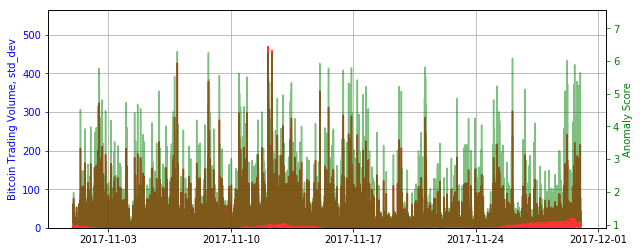

In [22]:
# Step 13: Plot the anomaly scores along with some features from the minute-level inferences
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#https://matplotlib.org/2.0.2/api/colors_api.html

ax1.plot(df_scored['Volume_(BTC)'], color='r', alpha=0.8)
ax1.plot(df_scored['Open'], color='b', alpha=1)
ax2.plot(df_scored['score'], color='g', alpha=.5)

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Bitcoin Trading Volume, std_dev', color='b')
ax2.set_ylabel('Anomaly Score', color='g')

ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='g')

ax1.set_ylim(0, 1.2*max(df_scored['Volume_(BTC)']))
ax2.set_ylim(min(df_scored['score']), 1.2*max(df_scored['score']))
fig.set_figwidth(10)

In [20]:
# Step 14: Anomalies are defined as scores greater than 3 standard deviations fronm the mean of score.

score_mean = df_scored['score'].mean()
score_std = df_scored['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = df_scored[df_scored['score'] > score_cutoff]
print("At a 3 sd threshhold, there are " + str(len(anomalies.score)) + " anomalies.")
anomalies.head()

At a 3 sd threshhold, there are 849 anomalies.


,Open,Volume_(BTC),Volume_(Currency),Weighted_Price,score
2017-11-01 09:46:00,6517.99,205.971929,1.344241e+06,6526.331237,4.516705
2017-11-01 11:44:00,6587.00,106.045187,6.987563e+05,6589.231402,2.638637
2017-11-01 14:11:00,6519.00,107.877962,7.037329e+05,6523.416223,2.648562
2017-11-01 16:04:00,6573.00,167.453450,1.101814e+06,6579.820554,3.924407
2017-11-01 16:28:00,6597.00,96.549983,6.373538e+05,6601.282975,2.429018


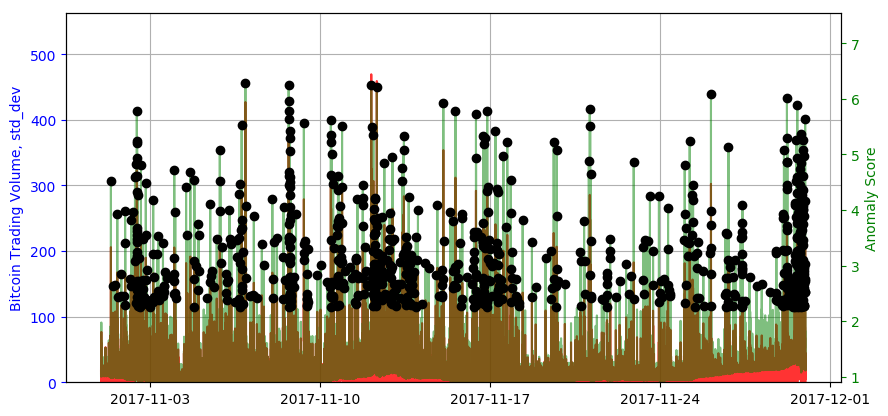

In [21]:
# Step 15: Add the anomalies to the plot.

ax2.plot(anomalies.index, anomalies.score, 'ko')
fig
